# Introduction to Machine Learning

D4G workshop

Potsdam, 13.06.22

Author: Caroline Arnold, DKRZ / Helmholtz AI

## Introduction

Welcome to Introduction to Machine Learning! Today we are going to work through the typical lifecycle of a machine learning project. We will be working with data from the CyGNSS satellite mission to predict global ocean wind speed.


### Setup

This tutorial could be done on a laptop, but for convenience we will use Google Colab.

1. Go to https://colab.research.google.com
2. Sign in with a google account
3. Open a new notebook (File > New notebook)
3. Clone the tutorial git repository by executing the following command (the "!" is important here!)

```bash
! git clone https://github.com/crlna16/d4g-tutorial
```

The data is stored separately in DKRZ nextcloud (Size: 121 MB). Download it by

```bash
TODO download address for the data
TODO check how to get the data into Google Colab
```

### Today's Goals

1. Walk through all stages of a machine learning project
1. Train a neural network using the Keras framework
1. Learn strategies to improve your machine learning algorithm
1. Optional: Get familiar with different neural network architectures

This notebook can serve as a reference for you to employ in your own scientific machine learning projects. We do not expect you to understand every single line of code!


<img src="./images/data-science-lifecycle8-3x.png" alt="Data Science Lifecycle" width="500" height="500" align="center">


## Scoping: Understanding the science case

The CyGNSS (Cyclone GNSS) is a system of microsatellites that measures GNSS reflected off the Earth's surface. We would like to predict the global ocean wind speed from CyGNSS measurements. This is a regression problem (the wind speed is a continuous variable). Data is available TODO source and license

<img src="./images/cygnss-from-space.png" alt="CyGNSS satellites and transmitter on top of a cyclone" title="CyNGSS satellites, Image courtesy of Milad Asgarimehr">

## Data cleaning

While it may be easy to obtain a lot of data, it is necessary to ensure the data quality, eg by checking for `None` values in the data. For the purpose of this tutorial, you can assume the data has been cleaned such that you can directly work with it.

## Data exploration

Now it is time to take a look at the data. We use the Python library `xarray` to open the `netcdf` files that are provided.

In [1]:
import xarray as xr
import numpy as np
np.random.seed(20220613)

In [2]:
ds_train = xr.open_dataset('../data/train_data.nc')

Interactive browser for the dataset # TODO check if this works in Google Colab

In [3]:
ds_train 

<xarray.Dataset>
Dimensions:       (sample: 63244, delay: 17, doppler: 11)
Coordinates:
  * sample        (sample) int64 0 1 2 3 4 5 ... 63239 63240 63241 63242 63243
  * delay         (delay) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * doppler       (doppler) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    windspeed     (sample) float32 ...
    ddm_nbrcs     (sample) float32 ...
    ddm_les       (sample) float32 ...
    sp_inc_angle  (sample) float32 ...
    brcs          (sample, delay, doppler) float32 ...
    eff_scatter   (sample, delay, doppler) float32 ...
Attributes:
    Summary:       CYGNSS is a NASA Earth Venture mission, managed by the Ear...
    Adapted from:  CYGNSS Science Operations Center, University of Michigan S...
    Source:        ​http://podaac.jpl.nasa.gov
    Used for:      Tutorial D4G workshop
    Split:         Train data

### Target variable

The target variable is the wind speed. To extract it:

In [4]:
y = ds_train['windspeed'].values

Visualization is very helpful for machine learning projects, as it helps us to identify the key properties of the dataset at a glance. We plot the distribution of the wind speed:

In [5]:
# Necessary libraries for plotting. Check out https://seaborn.pydata.org/ for reference
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('notebook')

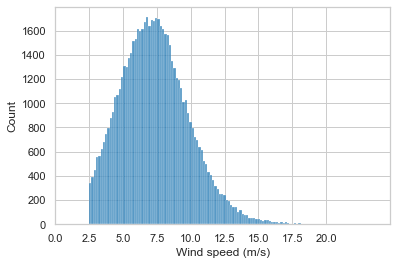

In [6]:
sns.histplot(y)

plt.xlabel('Wind speed (m/s)')
plt.xticks([0, 2.5, 5.0, 7.5, 10, 12.5, 15, 17.5, 20])

plt.show()

### Feature variables

There are 2D and 1D variables in the dataset (use the interactive dataset browser to check that). First, we extract the 2D variables and look at some selected samples.

#### BRCS (Bistatic Radar Cross Section)

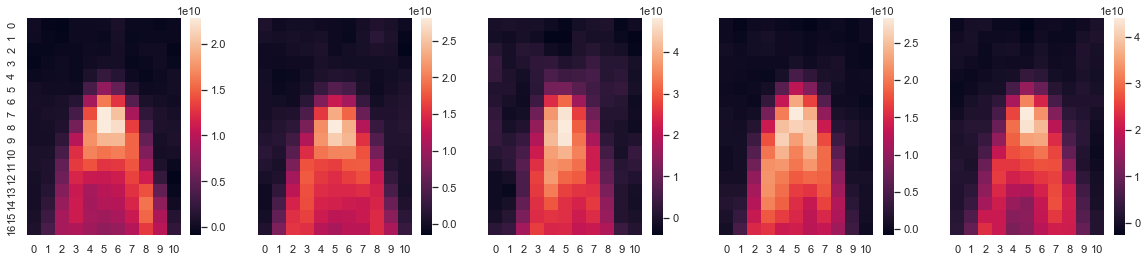

In [7]:
brcs = ds_train['brcs'][:]

fig, ax = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20,4))

for i in range(5):
    sns.heatmap(brcs[i*100], ax=ax[i])

#### Effective scatter map

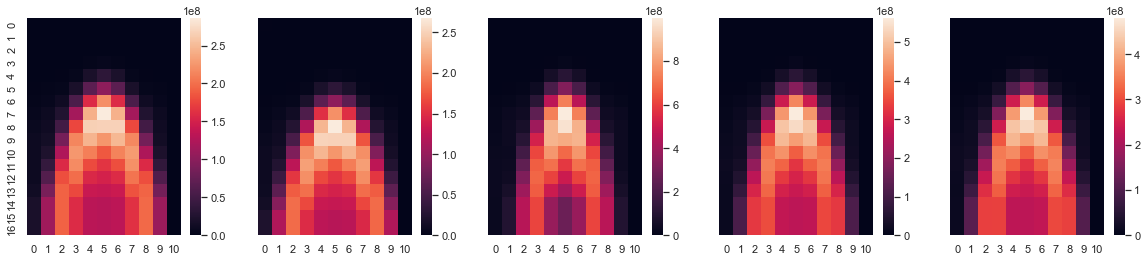

In [8]:
eff_scatter = ds_train['eff_scatter'][:]

fig, ax = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20,4))

for i in range(5):
    sns.heatmap(eff_scatter[i*100], ax=ax[i])


#### 1D variables

The dataset contains 1D variables as well. Here we can see the value ranges using histogram plots


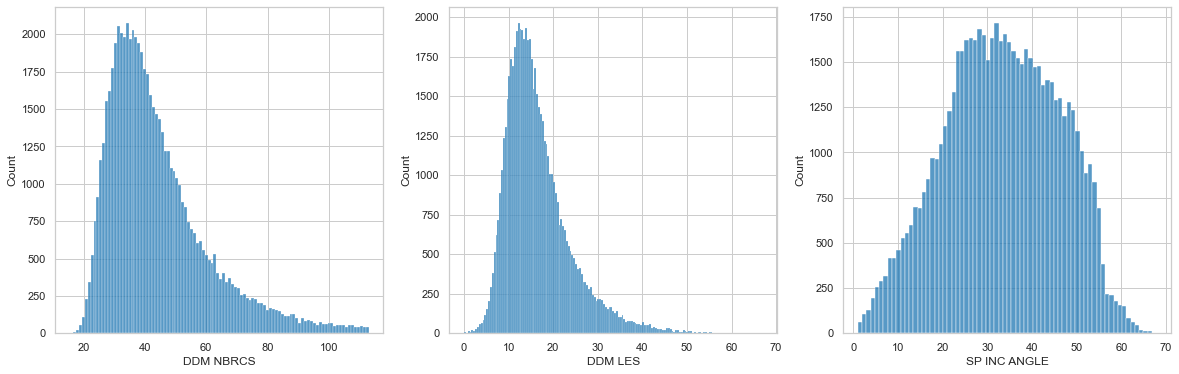

In [9]:
ddm_nbrcs = ds_train['ddm_nbrcs'][:]
ddm_les   = ds_train['ddm_les'][:]
sp_inc_angle = ds_train['sp_inc_angle'][:]

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(ddm_nbrcs, ax=ax[0])
ax[0].set_xlabel('DDM NBRCS')

sns.histplot(ddm_les, ax=ax[1])
ax[1].set_xlabel('DDM LES')

sns.histplot(sp_inc_angle, ax=ax[2])
ax[2].set_xlabel('SP INC ANGLE')

plt.show()

### Relation of feature and target variables

A machine learning algorithm can learn to approximate the relation between features $X$ and target variable $y$ based on data. Compared to traditional fitting algorithms, we do  not need to specify $f$ explicitly. A neural network can be trained to replace any kind of "well-behaved" non-linear function. It is often insightful to look at density plots of feature and target variables. We do this here for the 1D variables:

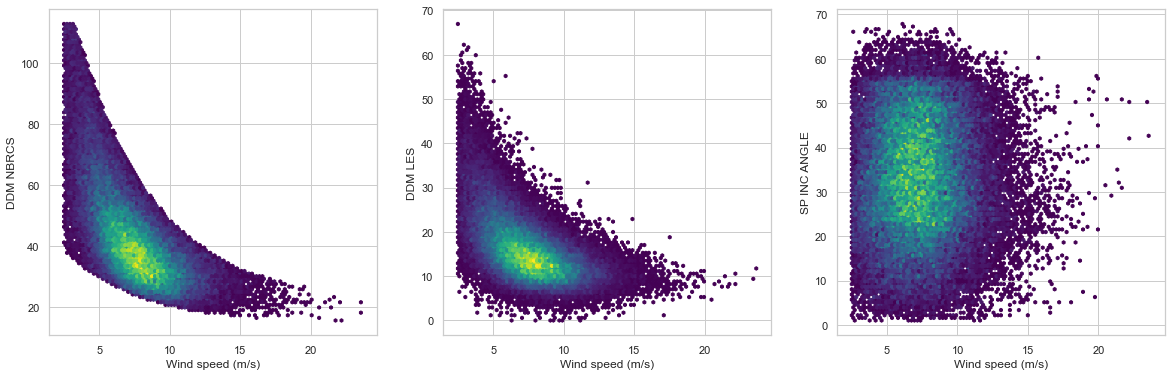

In [10]:
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20, 6))

ax[0].hexbin(y, ddm_nbrcs, mincnt=1, cmap='viridis')
ax[1].hexbin(y, ddm_les, mincnt=1, cmap='viridis')
ax[2].hexbin(y, sp_inc_angle, mincnt=1, cmap='viridis')

ax[0].set_xlabel('Wind speed (m/s)')
ax[0].set_ylabel('DDM NBRCS')

ax[1].set_xlabel('Wind speed (m/s)')
ax[1].set_ylabel('DDM LES')

ax[2].set_xlabel('Wind speed (m/s)')
ax[2].set_ylabel('SP INC ANGLE')

plt.show()

## Model development

Predictive modeling includes setting up a machine learning algorithm, training it and evaluating its performance. Our algorithm of choice is a neural network. We have prepared all the necessary code for you to train the algorithm.

### Prepare the input data

The data is split into *train*, *validation*, and *test* data. All three datasets have their distinct purpose:
1. Train data is given to the machine learning algorithm to tune the parameters of the neural network
1. Validation data is used to identify when the machine learning algorithm starts to overfit to the training data (we want to avoid learning the training data by heart)
1. Test data is used to gauge the ability of an ML algorithm to generalize. This dataset was not included at all in training and validation. We set it aside for now

In [11]:
def create_dataset(split, network='dense', normalize=True, verbose=True):
    '''
    Helper function to load the datasets that were prepared for this tutorial.
    
    Parameters:
    split       - Choice of [train, valid, test]
    network     - Choice of [dense, cnn]. Selects the appropriate 1D or 2D variables
    normalize   - Normalize features (default: True)
    verbose     - Print dataset information (default: True)
    
    Returns:
    
    (X, y) - Tuple of features and labels
    '''   
    
    if network == 'dense':
        input_keys = ['ddm_nbrcs', 'ddm_les', 'sp_inc_angle']
    elif network == 'cnn':
        input_keys = ['brcs', 'eff_scatter']
    else:
        raise ValueError('Unknown option: network = ', network)
    
    ds = xr.open_dataset(f'../data/{split}_data.nc')
    
    X = []
    
    for key in input_keys:
        var = ds[key][:]
        if normalize:
            var /= np.max(var)
        X.append(var)
        
    X = np.swapaxes(np.asarray(X), 0, 1)
    
    if len(X.shape) == 4: # images to channel_last
        X = np.swapaxes(X, 1, 3)
    
    y = np.array(ds['windspeed'][:])
    y = y[:, np.newaxis]
    
    print(f'Loaded data for split {split}')
    print(f'Feature array: {X.shape}')
    print(f'Label array:   {y.shape}')
    
    return X, y

In [12]:
X_train, y_train = create_dataset('train')
X_valid, y_valid = create_dataset('valid')

Loaded data for split train
Feature array: (63244, 3)
Label array:   (63244, 1)
Loaded data for split valid
Feature array: (10030, 3)
Label array:   (10030, 1)


### Introduction to neural networks

A single neuron takes an input $x$, applies a linear transformation $y = w \cdot x + b$, and ultimately applies a non-linear *activation function* $\sigma$, e.g., the relu function.

Therefore, a single neuron transforms the input $x$ like:

$y = \sigma( w \cdot x + b )$

The parameters $w, b$ are *learned* by exposing the neural network to training data. The dense neural network is a neural network that stacks several individual neurons together in *layers*. A forward pass through such a network can be written as 

$y = \sigma A( \sigma B (x))$

where $A, B$ are the weight matrices of the neural network.

<img src="./images/dense-neural-network.png" size="0.5">

### Define a neural network architecture

For convenience, we define a python function that can generate dense neural networks with various sizes. We use the *Keras* machine learning framework.

In [13]:
import tensorflow.keras as keras

def create_nn(H0=16, H1=8, input_dim=(3,)):
    '''
    Create a dense neural network with two hidden layers
    
    Parameters:
    H0 - Number of neurons in 1st hidden layer
    H1 - Number of neurons in 2nd hidden layer
    input_dim - Number of input features
    '''
    
    # Create a Keras input tensor
    inputs = keras.layers.Input(shape=input_dim)
    
    # Apply the first hidden layer
    hidden_layer = keras.layers.Dense(H0, activation='relu')(inputs)
    
    # Apply the second hidden layer
    hidden_layer2 = keras.layers.Dense(H1, activation='relu')(hidden_layer)
    
    # Reduce to one final output for the regression
    outputs = keras.layers.Dense(1)(hidden_layer2) 
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model 

Create a model with default parameters:

In [14]:
model = create_nn(H0=16, H1=8)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


We also need to define an optimizer that is the strategy to reach a minimum of the neural network parameter space. In Keras, this is done by compiling the model:

In [15]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())

### Train the neural network

In training, we show the training data to the neural network such that it can estimate the parameters. Then, the loss is calculated, here the mean squared error of true ($y$) vs predicted ($\hat y$) labels:

$\mathcal L = \frac 1 N \sum\limits_{i=1}^N (y_i - \hat y_i)^2$

Based on that, the neural network weights are adapted using backward propagation (advanced topic). We show the data to the network in *minibatches* for scalability and efficiency.

An important question is how we should know that we should *stop* training. In theory, we could train forever and ultimately reduce the loss on the training set to 0. That would not be helpful, because the model would then not generalize well to unseen data, a phenomenon known as *overfitting*. Therefore, we monitor the loss on the validation set during training, and stop training once this loss does no longer decrease.

In [16]:
max_epochs=200 # stop here in any case
batch_size=32

In [17]:
early_stopping=keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [18]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping],
                    epochs=max_epochs, 
                    batch_size=batch_size)

Epoch 1/200
1977/1977 [==============================] - 3s 1ms/step - loss: 7.7451 - val_loss: 3.1922
Epoch 2/200
1977/1977 [==============================] - 2s 1ms/step - loss: 3.0423 - val_loss: 3.0551
Epoch 3/200
1977/1977 [==============================] - 2s 1ms/step - loss: 3.0247 - val_loss: 3.0352
Epoch 4/200
1977/1977 [==============================] - 2s 1ms/step - loss: 3.0179 - val_loss: 2.9359
Epoch 5/200
1977/1977 [==============================] - 2s 1ms/step - loss: 3.0082 - val_loss: 2.9087
Epoch 6/200
1977/1977 [==============================] - 2s 1ms/step - loss: 3.0033 - val_loss: 2.9090
Epoch 7/200
1977/1977 [==============================] - 2s 1ms/step - loss: 3.0008 - val_loss: 3.0600s
Epoch 8/200
1977/1977 [==============================] - 2s 1ms/step - loss: 3.0008 - val_loss: 3.1414
Epoch 9/200
1977/1977 [==============================] - 2s 1ms/step - loss: 2.9960 - val_loss: 3.0091
Epoch 10/200
1977/1977 [==============================] - 2s 1ms/step - 

### Analyze the training process

Plot the history of the training process. The Keras framework automatically stored the training and validation loss for each epoch. 

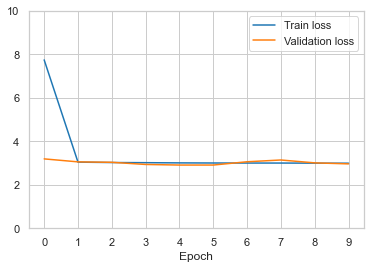

In [19]:
trained_epochs = len(history.history['loss'])

sns.lineplot(x=range(trained_epochs), y=history.history['loss'], label='Train loss')
sns.lineplot(x=range(trained_epochs), y=history.history['val_loss'], label='Validation loss')

plt.ylim(0, 10)

plt.xticks(range(trained_epochs))
plt.xlabel('Epoch')

plt.show()

### Improve the neural network

#### Single metric

We need to define a strategy to gauge the performance of the neural network. For that, we recommend to choose a single metric that is determined on the validation set and that you optimize step by step. In our case, this is the root mean squared error (RMSE). Calculate it below for the model we trained:

In [20]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_valid)

rmse = mean_squared_error(y_valid, y_pred, squared=False)

print(f'Root mean squared error (RMSE) obtained on validation set: {rmse:.4f} m/s')

Root mean squared error (RMSE) obtained on validation set: 1.7055 m/s


#### Next try

Change the parameters `H0, H1` of the neural network, as well as the batch size. What do you observe for the validation set results?

In [21]:
model2 = create_nn(H0=128, H1=64)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
_________________________________________________________________


In [22]:
model2.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())

history = model2.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping],
                    epochs=max_epochs, 
                    batch_size=batch_size, 
                    verbose=1)

Epoch 1/200
1977/1977 [==============================] - 3s 1ms/step - loss: 4.8321 - val_loss: 3.1468
Epoch 2/200
1977/1977 [==============================] - 3s 1ms/step - loss: 3.0452 - val_loss: 2.9479
Epoch 3/200
1977/1977 [==============================] - 3s 1ms/step - loss: 3.0265 - val_loss: 2.9736
Epoch 4/200
1977/1977 [==============================] - 3s 1ms/step - loss: 3.0133 - val_loss: 2.8910
Epoch 5/200
1977/1977 [==============================] - 3s 1ms/step - loss: 3.0071 - val_loss: 3.1504
Epoch 6/200
1977/1977 [==============================] - 3s 1ms/step - loss: 3.0052 - val_loss: 2.9363
Epoch 7/200
1977/1977 [==============================] - 3s 1ms/step - loss: 3.0075 - val_loss: 2.9538loss: 
Epoch 8/200
1977/1977 [==============================] - 3s 2ms/step - loss: 2.9964 - val_loss: 2.8992 lo
Epoch 9/200
1977/1977 [==============================] - 3s 2ms/step - loss: 2.9967 - val_loss: 2.9475


In [23]:
y_pred = model2.predict(X_valid)

rmse = mean_squared_error(y_valid, y_pred, squared=False)

print(f'Root mean squared error (RMSE) obtained on validation set: {rmse:.4f} m/s')

Root mean squared error (RMSE) obtained on validation set: 1.7003 m/s


Compare the RMSE to the RMSE you obtained before with the default architecture. Do you see an improvement?

Optional: Try out more architectures

### Advanced topic: Convolutional neural network (CNN)

Remember that the dataset contains 2D variables as well, which we did not use so far. These can be seen as images. Convolutional neural networks originated in computer vision and were originally developed for the image classification. We adapt here a convolutional neural network for regression.

<img src="./images/d4g-cnn-sketch.png">

In [24]:
def create_cnn(n_filters=16, H0=64, H1=32):
    '''
    Create a convolutional neural network. The architecture has 2 convolutional layers, followed by two dense layers.
    
    Parameters:
    n_filters - number of filters in the convolutional layer
    H0        - number of neurons in the dense layer
    '''
    
    inputs = keras.layers.Input(shape=(11, 17, 2))
    conv_layer1 = keras.layers.Conv2D(n_filters, 3, activation="relu")(inputs)
    pooling_layer = keras.layers.MaxPool2D()(conv_layer1)
    conv_layer2 = keras.layers.Conv2D(n_filters, 3, activation="relu")(pooling_layer)
    pooling_layer2 = keras.layers.MaxPool2D()(conv_layer2)
    flatten_layer = keras.layers.Flatten()(pooling_layer2)
    dense_layer = keras.layers.Dense(H0, activation="relu")(flatten_layer)
    dense_layer2 = keras.layers.Dense(H1, activation="relu")(dense_layer)
    outputs = keras.layers.Dense(1)(dense_layer2)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

We create training and validation data this time using the image data part of the provided CyGNSS dataset:

In [25]:
X_train_cnn, _ = create_dataset('train', network='cnn')
X_valid_cnn, _ = create_dataset('valid', network='cnn')

Loaded data for split train
Feature array: (63244, 11, 17, 2)
Label array:   (63244, 1)
Loaded data for split valid
Feature array: (10030, 11, 17, 2)
Label array:   (10030, 1)


In [26]:
model_cnn = create_cnn(n_filters=32, H0=128, H1=64)
model_cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 11, 17, 2)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 15, 32)         608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320

In [ ]:
model_cnn.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())

history = model_cnn.fit(X_train_cnn, y_train, 
                    validation_data=(X_valid_cnn, y_valid), 
                    callbacks=[early_stopping],
                    epochs=max_epochs, 
                    batch_size=batch_size, 
                    verbose=1)

Epoch 1/200
1977/1977 [==============================] - 13s 6ms/step - loss: 4.0254 - val_loss: 3.9284
Epoch 2/200
1977/1977 [==============================] - 7s 4ms/step - loss: 3.0952 - val_loss: 3.4143
Epoch 3/200
1304/1977 [==================>...........] - ETA: 2s - loss: 3.0295

In [ ]:
rmse = mean_squared_error(y_valid, model_cnn.predict(X_valid_cnn), squared=False)
print(f'RMSE for the CNN: {rmse:.4f} m/s')

To summarize the results that were obtained on the *validation* set:

1. Dense neural network

| H0 | H1 | batch size | RMSE |
|--  |--  |--          | --   |
| 16 | 8  | 32        | 1.7085 m/s |
| 128 | 64 | 32       | 1.6956 m/s |


2. Convolutional neural network

| Filters | H0 | H1 | batch size | RMSE |
|--       |--  |--  |--          |--    |
| 16      | 64 | 32 | 32         | 1.7655 m/s |
| 32      | 128 | 64 | 32        | 1.7512 m/s |

## Evaluation

Finally, we use our model to predict wind speeds for the test set. So far, we did not touch this dataset, so it should give an idea how well our machine learning algorithm generalizes to unseen data. We repeat the dataset preparation for the test set

In [ ]:
X_test, y_test = create_dataset('test', network='dense')
X_test_cnn, _ = create_dataset('test',  network='cnn')

Choose one of the model architectures that you think perform well on the given dataset. If necessary, train this model again. Use the trained model to make predictions on the test set.

In [ ]:
# TODO train again if necessary

best_model = model2

In [ ]:
#y_pred = best_model.predict(X_test_cnn) # if CNN was best model
y_pred = best_model.predict(X_test) # if ANN was best model

## Data visualization

Calculate metrics to report on the performance of your machine learning algorithm. Compare the test set RMSE with the validation RMSE. What do you observe?

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'Root mean squared error (RMSE) for the test set: {rmse:.4} m/s')

### Histogram plot

In a regression problem, it is interesting to see the performance of the machine learning algorithm beyond the aggregated RMSE metric. We plot the histogram of true windspeed and predicted windspeed. What do you observe? Can you identify a windspeed range where our machine learning algorithm performs poorly? What are possible explanations?

In [ ]:
fig, ax = plt.subplots(1, 1)

sns.distplot(y_test.squeeze(), color='gray', label='True wind speed', ax=ax)
sns.distplot(y_pred.squeeze(), color='C2', label='Predicted wind speed', ax=ax)

ax.legend()
ax.set_xlabel('Wind speed (m/s)')

plt.show()

In [ ]:
# 2D scatter plot

fig, ax = plt.subplots(1, 1)

ax.set_aspect('equal')

img = ax.hexbin(y_test.squeeze(), y_pred.squeeze(), mincnt=1, cmap='viridis')

ax.set_xlabel('ERA5 wind speed (m/s)')
ax.set_ylabel('Predicted wind speed (m/s)')

xmin = 0
xmax = 20

ax.plot(np.linspace(xmin, xmax), np.linspace(xmin, xmax), 'r--')

ax.set_ylim(xmin, xmax)
ax.set_xlim(xmin, xmax)

plt.colorbar(img, label='Sample density')

plt.show()

Discussion: Overall, it is possible to obtain reasonable windspeed predictions even with the small set of training samples that was provided here in the tutorial. However, the prediction tends towards the mean windspeed value, which means that low windspeeds are overestimated and high windspeeds are underestimated. This is known as *regression to the mean* and applies to all statistical algorithms. Note that the windspeed distribution is not uniform, and therefore the algorithm is presented more often with average samples compared to samples with high windspeed.

Related publication:

Asgarimehr, M., Arnold, C., Weigel, T., Ruf, C. & Wickert, J. GNSS reflectometry global ocean wind speed using deep learning: Development and assessment of CyGNSSnet. Remote Sensing of Environment 269, 112801 (2022).

    
    